### **Analysis of the effect of a TheraTech drug on the treatment of cancer patients.**
##### Assessment 3
###### by Matthew Parker

In this notebook, pre- and post-treatment data provided by TheraTech for six markers is analysed and used to give a quantitative value for the percentage of people who's health improved after being treated with the drug.  

### Initial Setup of Notebook

In [ ]:
# The imports used throughout this notebook 
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture 
from sklearn.preprocessing import scale


from functions import update_marker, plot_markers, append_pc, vary_num_components, plot_clusters2, filter_patients, update_communality

In [52]:
# Make notebook interactive
%matplotlib ipympl

### Loading and showing the provided data

In [53]:
# Load in the data provided by TheraTech.
post_data = pd.read_csv('datasets/post_cancer_markers.csv')
pre_data = pd.read_csv('datasets/pre_cancer_markers.csv')

# List of just the column names. Used later. 
marker_names = post_data.columns[:6]

# A sample of one of the dataframes to show how the data is provided. 
# Only the first 5 rows of 2000 are shown.
post_data.head()

,marker_0,marker_1,marker_2,marker_3,marker_4,marker_5
0,2.990886,402.749657,438.974363,0.100059,4.979045,3.968637
1,2.975415,405.002356,440.841705,0.099766,4.970699,3.927863
2,3.001451,400.946927,438.262832,0.100913,4.983885,3.970726
3,3.005054,401.368032,437.023273,0.100155,4.983348,3.967905
4,2.982323,416.039853,444.240176,0.101435,4.996187,3.971283


### Interactive display to show the raw data 

In the following cell, an interactive figure allows exploration of the raw data. 
There is an integer slider widget that allows easy changing between data for each marker. 

Furthermore, a dropdown menu gives the option to see a 2d scatter plot of the pre data against the post data, or histograms of these two sets of data separately.
This allows the viewer to see the pre- and post-treatment data distributions separately, as well as how they relate to each other for each marker.

interactive(children=(IntSlider(value=0, description='Marker number:', max=5, style=SliderStyle(description_wi…

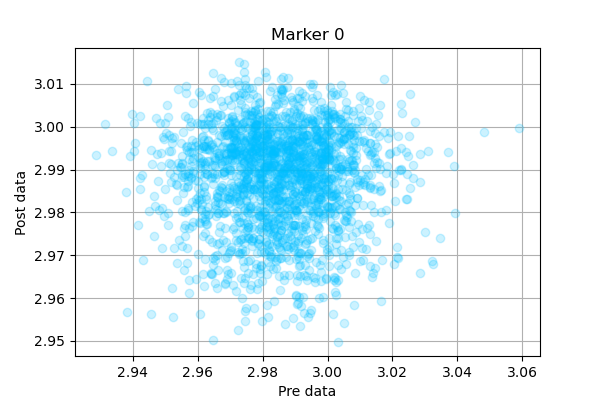

In [54]:
# Interactive plotting using above updater function.

# List of the different options for data to view.
viewing_options = ['Pre and Post data', 'Pre data', 'Post data']

# Allows viewing of full slider name.
style = {'description_width': 'initial'} 
 
# # Initialises figure   
fig, ax = plt.subplots(figsize=(6,4))

# Makes widget, with an integer slider to change marker number, and a drop down menu to see the different data distributions.  
widgets.interact(update_marker, 
                 marker_num=widgets.IntSlider(min=0, max=5, step=1, orientation='horizontal', description='Marker number:', style=style),
                 view=viewing_options,
                 pre_data=widgets.fixed(pre_data), post_data=widgets.fixed(post_data), 
                 viewing_options=widgets.fixed(viewing_options), ax=widgets.fixed(ax), fig=widgets.fixed(fig));

Exploring that data, some initial patterns and clusters can be seen, before any data analysis is done. 

Overall, the pre-treatment data is generally normally distributed for all six markers. However, the post data is more variable, with markers 1 and 2 having two peaks, and marker 0 showing a slight skew. The two peaks of markers 1 and 2 can be seen as clusters in the plot of pre- data against post-treatment data. These clusters will likely be related to the effectiveness of the drug, with improved patients and unimproved patients potentially splitting into separate clusters.  

### Comparison and Correlation between Markers




In the following plot, the correlation between all possible combinations of markers are plotted, to provide a rapid overview of which markers are most strongly correlated.

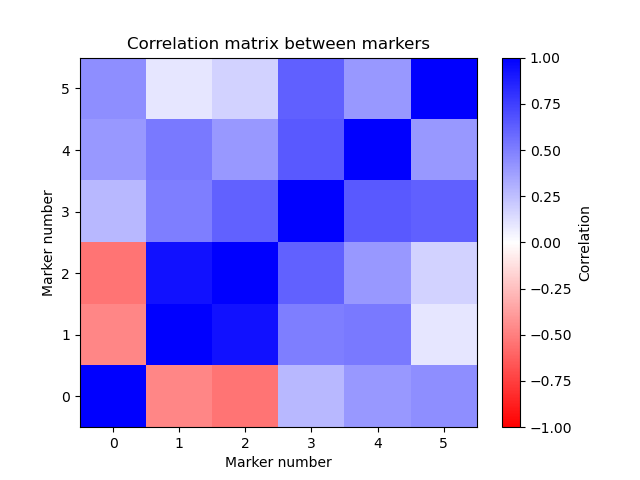

In [55]:
# Calculation of correlation values between every combination of markers

# iloc used to ensure the pca columns are not used. 
corr_matrix = post_data.iloc[:, :6].corr()

fig, ax = plt.subplots()

# The choice of colour allows clear distinction between strong correlation, no correlation, and strong anti-correlation.
im = ax.imshow(corr_matrix, aspect="auto", cmap='bwr_r', vmax=1, vmin=-1)
colourbar = plt.colorbar(im)  
colourbar.ax.set_ylabel("Correlation")
ax.set_xlabel("Marker number")
ax.set_ylabel("Marker number")
ax.set_title("Correlation matrix between markers")

# Makes both axes increase 
ax.invert_yaxis()

plt.show()


This figure shows that markers 1 and 2 are very strongly correlated with a value of 0.927. Also, it shows that marker 0 is anticorrelated with both marker 1 and marker 2. Furthermore, it can observed that there is very little correlation between marker 5 and markers 1 and 2 with correlation values of 0.100 and 0.175 respectively. 

The values on the diagonal all have a value of exactly 1 because each of the markers are perfectly correlated with themselves.


The following cell provides an interactive graph plotting of the post data of different markers against each other, as well as printing the calculated correlation value. 
This shows how the different markers are related to each other, and allows visualisation of how the values in the above matrix originate from. 

In [56]:
# Initialises plot
fig, ax = plt.subplots()

# Define marker options
marker_options = marker_names

# Display the interactive plot with the two dropdowns
widgets.interactive(plot_markers, 
                    marker_x=widgets.Dropdown(options=marker_options, value='marker_0', description='Marker x:'),
                    marker_y=widgets.Dropdown(options=marker_options, value='marker_1', description='Marker y:'),
                    post_data=widgets.fixed(post_data), ax=widgets.fixed(ax), fig=widgets.fixed(fig))

interactive(children=(Dropdown(description='Marker x:', options=('marker_0', 'marker_1', 'marker_2', 'marker_3…

### Application and analysis of Principal Component Analysis (PCA) to the data

In [57]:
# Run pca for post and pre data and append columns onto each dataframe. 

post_data, pca_post_6 = append_pc(post_data)
pre_data, pca_pre_6 = append_pc(pre_data)


In [58]:
# Shows updated version of post data dataframe (pre_data dataframe will have the same structure), with PC analysis included. 
post_data.head()

,marker_0,marker_1,marker_2,marker_3,marker_4,marker_5,PC1,PC2,PC3,PC4,PC5,PC6
0,2.990886,402.749657,438.974363,0.100059,4.979045,3.968637,-0.627693,0.316713,0.089387,-0.322680,0.127195,0.019898
1,2.975415,405.002356,440.841705,0.099766,4.970699,3.927863,-1.000818,-1.943035,0.125203,0.388630,0.196648,0.082372
2,3.001451,400.946927,438.262832,0.100913,4.983885,3.970726,-0.379784,1.486636,-0.360363,0.067556,0.032764,0.014674
3,3.005054,401.368032,437.023273,0.100155,4.983348,3.967905,-0.910490,1.662760,-0.631282,-0.269946,0.410479,0.012620
4,2.982323,416.039853,444.240176,0.101435,4.996187,3.971283,3.147673,-1.014427,-1.043033,-0.896462,0.247482,0.031069


In [59]:
# Get list of new column names
pc_names = post_data.columns[6:]


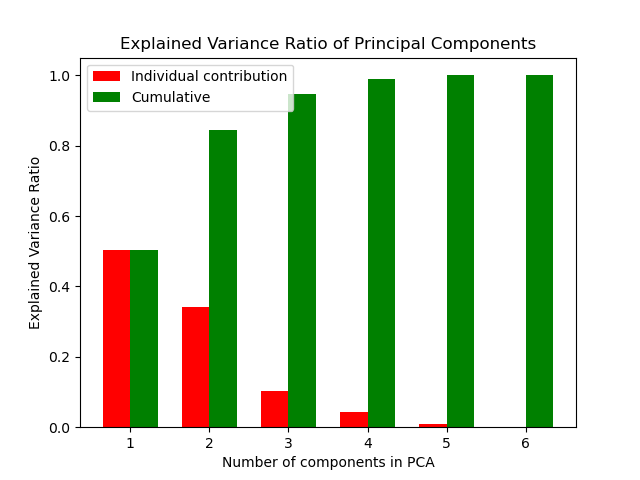

In [60]:
# Graph to show the explained variance ratio (EVR) provided with each principal component.
# Shows both the individual EVR from each component, as well as the cumulative sum up to and including each component. 

# EVR calculated for each component
# Cumulative sum also calculated
evr  = pca_post_6.explained_variance_ratio_
cumsum = evr.cumsum()

# X axis for graph - number of components. 
x_vals = np.arange(1,len(cumsum)+1)

# Width of the bars
width = 0.35  

# Plot 2 bars for each component
fig, ax = plt.subplots()
individual_evr = ax.bar(x_vals - width / 2, evr, width, label='Individual contribution', color='red')
cumulative_evr = ax.bar(x_vals + width / 2, cumsum, width, label='Cumulative', color='green')

# Improve graph visuals
ax.set_ylabel("Explained Variance Ratio")
ax.set_xlabel("Number of components in PCA")
ax.set_title("Explained Variance Ratio of Principal Components")
leg = ax.legend()
plt.show()

The above figure shows that one principal component explains only 50% of the of the variance of the provided data. However, this value increases significantly to over 80% when two components are used. This suggests that using two principal components should cover a suitable amount of the variance of the dataset. 


### Interactive graphs to show the results of the PCA 
**Rewrite**

The following piece of code shows the results after running the pca analysis on both the pre- and post-treatment data and plotting the first two principal components against each other. These results are plotted side by side, to emphasise the clusters that form in the post data analysis. 

These clusters are very clear in the 2d and 3d plots. 
For completeness, the analysis using just one component was used, which shows no clear pattern in the post data. 

In [61]:
# Widget 

# 1d put last because it is least relevant
dimensions_options = ['2d', '3d', '1d']
titles = ['Pre data', 'Post data']

# Drop down menu to switch between number of dimensions/components used. 
widgets.interact(vary_num_components,
                 num_dims=widgets.Dropdown(options=dimensions_options, value='2d', description='Number of dimensions:', style=style),
                 pre_data=widgets.fixed(pre_data), post_data=widgets.fixed(post_data), titles=widgets.fixed(titles), ax=widgets.fixed(ax), fig=widgets.fixed(fig));

interactive(children=(Dropdown(description='Number of dimensions:', options=('2d', '3d', '1d'), style=Descript…

The following cells run a Gaussian Mixture model on the PCA in 2d, to show the clusters formed. 

Patient zero is also plotted with a black star to show which cluster they fall into. This is used to determine which cluster contains the improved patients, and which cluster contains the unimproved patients. 

In [62]:
# Function used to show clusters 

def plot_clusters(num_dims, n_clusters, post_data):
    """
    Function that takes an array containing the pca axes and plots the clusters formed by them. 

    Args:
        X (array): Array containing pc1 in first column, pc2 in second column, etc. 
        n_clusters (int, optional): Number of clusters to form. Defaults to 2.

    Returns:
        array: array of labels, with 1 representing data points in the same cluster as the data from the first row. 
    """

    global labels, inv_labels
    
    # Make array of the first n principal components of the post data. 
    x_gauss = post_data['PC1']
    y_gauss = post_data['PC2']
    z_gauss = post_data['PC3']

    if num_dims=='2d':
        X_gauss = np.array([x_gauss, y_gauss]).T
        
    elif num_dims=='3d':
        X_gauss = np.array([x_gauss, y_gauss, z_gauss]).T  
    
    # Define constants
    X = X_gauss
    dims = X.shape[1]
    
    
    # Run Gaussian Mixture Model to obtain the two clusters. 
    gauss_mix = GaussianMixture(n_components=n_clusters)
    gm_fitted = gauss_mix.fit(X)
    labels = gm_fitted.predict(X)
    probabilities = gm_fitted.predict_proba(X)
    size = 10 * probabilities.max(axis=1) ** 2

    # Ensures improved patients are always marker as 1, and unimproved patients marked as zero
    # Relevant later
    if labels[0]==0:
        labels = abs(labels-1)
    
    # Unimproved patients now marked as 1
    inv_labels  = abs(labels-1)

    # Colours of clusters
    colour_list = ListedColormap(['red', 'deepskyblue'])

    # Plot
    if dims==2:
        fig, ax = plt.subplots(figsize=(6, 4))
        ax.scatter(X[:, 0], X[:, 1], c=labels, cmap=colour_list, s=size, alpha=0.25)
        ax.scatter(X[0, 0], X[0, 1], s=size[0], marker='*', color='black')
    
    if dims==3:
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels, cmap=colour_list, s=size, alpha=0.15)
        ax.set_zlabel('PC3')

        
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_title('Clusters formed from plotting PC1 against PC2')
    plt.show();
    
    return labels, inv_labels
    

In [63]:
# GMM to show clusters in 2d/3d

# initialise values to be returned from function
labels, inv_labels = None, None

n_clusters = 2

# Drop down menu to switch between number of dimensions used. 
# Exclude 1d from drop-down options
widgets.interact(plot_clusters,
                 num_dims=widgets.Dropdown(options=dimensions_options[:-1], value='2d', description='Number of dimensions:', style=style),
                 n_clusters=widgets.fixed(n_clusters), post_data=widgets.fixed(post_data));

interactive(children=(Dropdown(description='Number of dimensions:', options=('2d', '3d'), style=DescriptionSty…

### Results

The percentage of patients who improved is calculated here, as well as interactive plots to see how each marker contributed to getting the results. 

In [64]:
# Number of patients in same cluster as patient zero
num_improved = len(labels[labels==labels[0]])

total_people = len(labels)
percentage_improved = 100 * num_improved / total_people

print(f"Number of people in same cluster as first person: {num_improved}")
print(f"Percentage of people the drug worked for: {percentage_improved:.1f}%")

Number of people in same cluster as first person: 1431
Percentage of people the drug worked for: 71.5%


The following cell produces an interactive graph that allows the viewer to toggle on/off whether to view the improved patients, the unimproved patients, or patient zero, either separately or simultaneously. This is done for each marker, with an integer slider to see the results for each marker. Furthermore, the dropdown menu gives the option to see this as a 2d scatter plot of the pre data against the post data, or histograms of these two sets of data separately.

 This allows the viewer to see the improved/unimproved distributions separately, as well as how they relate to the pre data for each marker. 






In [65]:
def update_data_viewer(marker_num, view, viewing_options, pre_data, post_data, ax, fig, Improved_patients=True, Unimproved_patients=True, Patient_zero=False):
    """
    Updater function to allow the viewer to slide through the data for each marker.
    Shows the relationship between pre and post data, as well as allows viewer to see the distributions of the pre/post data separately. 
    Also allows viewing of improved/unimproved/patient zero or any combo of these options for each marker number

    Args:
        marker_num (int): Which marker the viewer wants to see. 
        histogram (str): Which data the viewer wants to see. 
    """
    
    # Creates array of the pre and post data for the required marker
    marker_i_pre = pre_data[f'marker_{marker_num}']
    marker_i_post = post_data[f'marker_{marker_num}']

    # Clears previous data. 
    ax.cla()
    
    improved_pre = filter_patients(marker_i_pre, labels)  
    improved_post = filter_patients(marker_i_post, labels)
    unimproved_pre = filter_patients(marker_i_pre, inv_labels)  
    unimproved_post = filter_patients(marker_i_post, inv_labels)  
    
    # Scatter plot of pre data and post data
    if view==viewing_options[0]:
        
        if Unimproved_patients==True:
            ax.scatter(unimproved_pre, unimproved_post, alpha=0.2, label='Unimproved patients', color='red') 
        if Improved_patients==True:
            ax.scatter(improved_pre, improved_post, alpha=0.2, label='Improved patients', color='deepskyblue') 
        if Patient_zero==True:
            ax.scatter(improved_pre[0], improved_post[0], color='black', marker='*', label='Patient Zero')   
             
        ax.set(xlim=(0.999*np.min(marker_i_pre), 1.001*np.max(marker_i_pre)), ylim=(0.999*np.min(marker_i_post), 1.003*np.max(marker_i_post)))
        ax.set_xlabel('Pre data')
        ax.set_ylabel('Post data')
        ax.legend(loc='upper left')
        
    # Histogram to show distribution of post data  
    elif view==viewing_options[1]:
        
        bins=100
        improved_post = improved_post[~np.isnan(improved_post)] 
        unimproved_post = unimproved_post[~np.isnan(unimproved_post)] 
        
        counts1  = np.histogram(improved_post, bins=bins)[0]
        counts2 = np.histogram(unimproved_post, bins=bins)[0]
    
        max_counts_arr = [np.max(counts1), np.max(counts2)]
        max_counts = np.max( max_counts_arr )
                
        if Unimproved_patients==True:
            ax.hist(unimproved_post, bins=bins, orientation='horizontal', label='Unimproved patients', color='red', alpha=0.2)
        if Improved_patients==True:
            ax.hist(improved_post, bins=bins, orientation='horizontal', label='Improved patients', color='deepskyblue', alpha=0.2)
        ax.set_xlabel('Frequency')   
        ax.legend()
        ax.set(xlim=(0, 1.1*max_counts), ylim=(0.999*np.min(marker_i_post), 1.003*np.max(marker_i_post)))
        
        
    ax.set_ylabel('Post data')   
    ax.set_title(f'Marker {marker_num}')
    ax.grid()
    ax.set_axisbelow(True)

    fig.canvas.draw()

interactive(children=(IntSlider(value=0, description='marker_num', max=5), Dropdown(description='view', option…

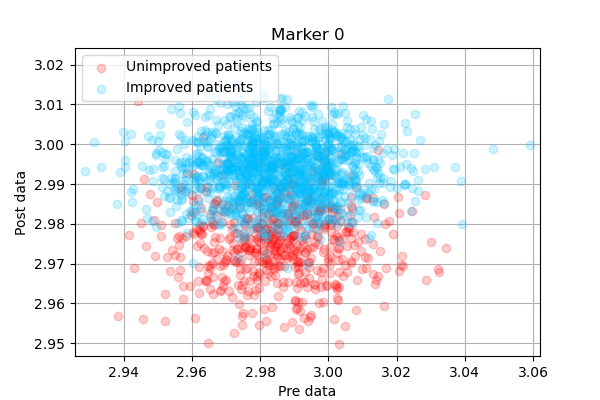

In [66]:
# Widget called to produce graph

# List of the different options for data to view
viewing_options = ['Pre and Post data', 'Post data']
 
# Initialises required figure   
fig, ax = plt.subplots(figsize=(6,4))

# Makes widget, with an integer slider to change marker number, and a drop down menu to see the different data distributions.  
widgets.interact(update_data_viewer, 
                 marker_num=widgets.IntSlider(min=0, max=5, step=1, orientation='horizontal'),
                 view=viewing_options,
                 viewing_options=widgets.fixed(viewing_options), pre_data=widgets.fixed(pre_data), post_data=widgets.fixed(post_data),ax=widgets.fixed(ax), fig=widgets.fixed(fig));


There are some key points to see from this widget. It can be seen that the improved patients mostly fit into one of the two clusters in markers 1 and 2, and the unimproved patients in marker 0 tend to be lower down in the scatter plot. On the other hand, markers 3, 4, and 5 seem to show the improved and unimproved patients distributed evenly across the data. 

This suggests that the first three markers may be more important in determining if a patient has improved or not, whereas the last three markers do not provide much information. 

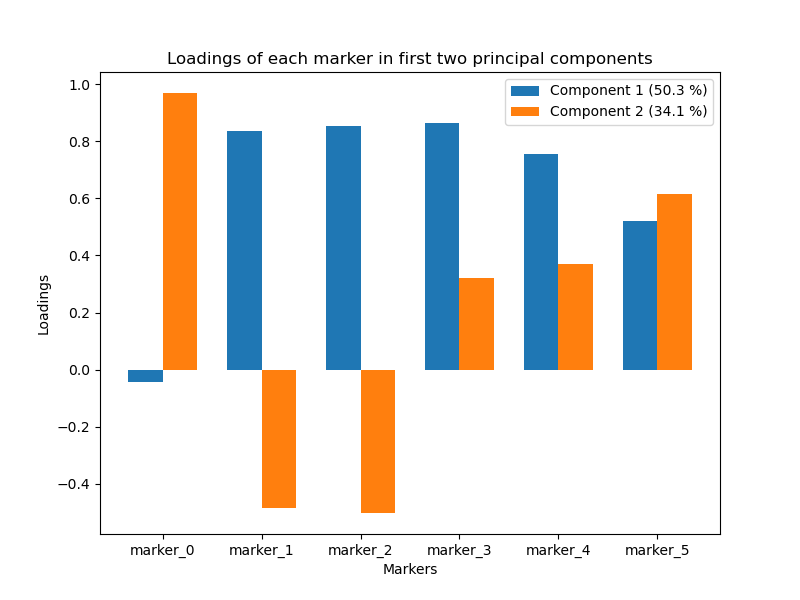

In [67]:
# Loadings of each marker in each PCA component. 

n_bars = 6
num_pca_components=2
loading_matrix = pd.DataFrame(pca_post_6.components_.T[:, :n_bars] * np.sqrt(pca_post_6.explained_variance_[:n_bars]), 
                              columns=pc_names, index=marker_names)

# Indices for the six markers
ind = np.arange(len(loading_matrix.index))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))

# Plot each bar
for i in range(0,num_pca_components):
       ax.bar(ind + i*width, loading_matrix[f'PC{i+1}'], width, 
       label=f'Component {i+1} ({100*pca_post_6.explained_variance_ratio_[i]:.1f} %)')

ax.set_xlabel('Markers')
ax.set_ylabel('Loadings')
ax.set_title('Loadings of each marker in first two principal components')

# Puts x ticks in centre of bars
ax.set_xticks(ind + (num_pca_components-1)*(width / 2) )
ax.set_xticklabels(loading_matrix.index)
ax.tick_params(axis='x') 
ax.legend()
plt.show()

### Biplot of components

The loadings of each bar chart for the first two components are plotted as a biplot on the graph of PC1 against PC2. The arrows show the loadings of each marker for the first two principal components. 

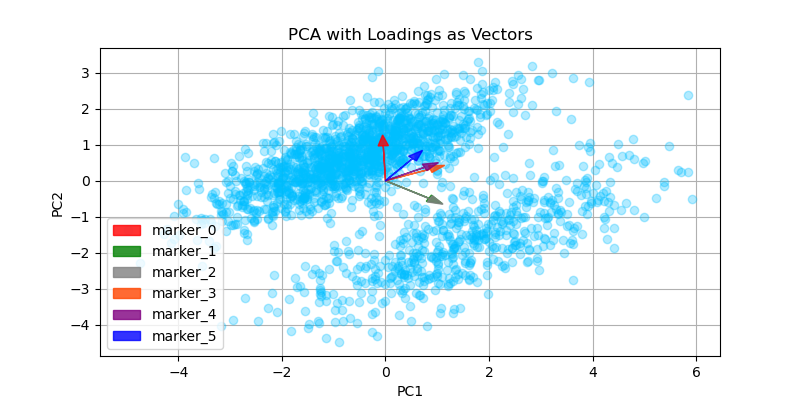

In [68]:
# Biplot

# Plot pc1 vs pc2. 
fig, ax = plt.subplots(figsize=(8, 4))

PC1_post = post_data['PC1']
PC2_post = post_data['PC2']

# Plot pc1 against pc2
ax.scatter(PC1_post, PC2_post, alpha=0.3, color='deepskyblue')

# Colours of arrows
colours = ['red', 'green', 'grey', 'orangered', 'purple', 'blue']

# Add arrows showing loadings in pc1 and pc2. 
for i in range(loading_matrix.shape[0]):
    plt.arrow(0, 0, loading_matrix.iloc[i, 0], loading_matrix.iloc[i, 1], 
              head_width=0.2, color = colours[i], alpha=0.8,
              label=post_data.columns[i])  
    
# Setting labels and title
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('PCA with Loadings as Vectors')

ax.grid()
ax.set_axisbelow(True)
ax.legend(loc='lower left')
plt.show()



The plot above indicates that markers 1 and 2 play the most significant roles in defining the clusters, with marker 0 also contributing but to a lesser extent. This can be seen by how the arrows for these markers have large components in the direction pointing from one cluster to the other. 

On the other hand, markers 3, 4, and 5 have large components parallel to the direction of the clusters. This means they contribute more to the width of the clusters, rather than the separation of the clusters. 


### Communality

The following plot has an interactive widget to show the communality of each marker. 

Communality is a calculation of how much the total variance of *each marker* is explained by a certain number of principal components.
A larger communality indicates that more of a marker's variance is explained, which means that the principal components show more of that marker’s information within the reduced-dimension space.

This tool allows exploration of how well the variance of each marker is explained across a variable number of principal components. 


interactive(children=(IntSlider(value=1, description='num_components', max=6, min=1, style=SliderStyle(descrip…

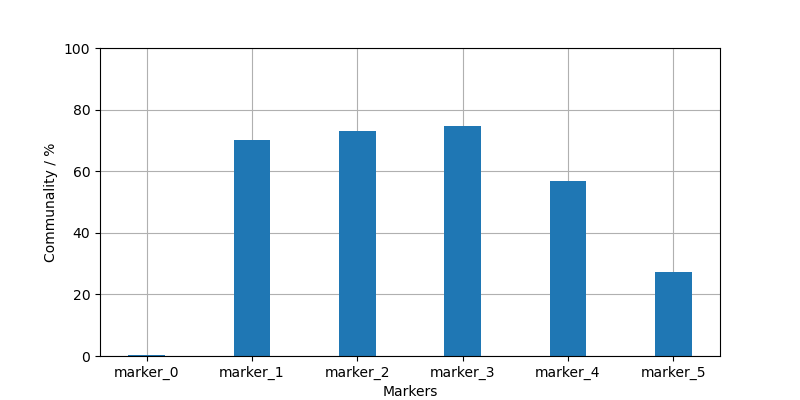

In [69]:
# Interactive communality plot
# Calculates how much of the total variance of each marker is explained by a variable number of principal components. 

# bar width
width=0.35

# Initialise figure
fig, ax = plt.subplots(figsize=(8,4))

# Integer slider widget
widgets.interact(update_communality, 
                 num_components=widgets.IntSlider(min=1, max=6, step=1, orientation='horizontal', style=style),
                 loading_matrix=widgets.fixed(loading_matrix), marker_names=widgets.fixed(marker_names), width=widgets.fixed(width), ax=widgets.fixed(ax), fig=widgets.fixed(fig));